In [39]:
import itertools
import numpy as np

tol = 1e-12

# Linear programming problem

Consider problem:
$\min_{x\in\mathbb{R}^m}\ b^T x$
with constraints
$Cx - d = 0,$
$x \ge 0,$

gdzie:
- $b \in \mathbb{R}^m$,
- $d \in \mathbb{R}^p$,
- $C : \mathbb{R}^{p\times m}$,
- $\operatorname{rank} C = p$, $1 \le p < m$.


In [40]:
def eval_basis(C, d, b, B):
    """
    Dla danej bazy B oblicza punkt bazowy.

    Zwraca slownik:
      x_B      - wektor zmiennych bazowych (w kolejnosci B)
      feasible - czy punkt jest dopuszczalny
    """
    p, m = C.shape

    C_B = C[:, B]
    if (np.linalg.matrix_rank(C_B) < p):
        return {
            "x_B": None,
            "feasible": False
        }
    
    x_B = np.linalg.solve(C_B, d)

    return {
        "x_B": x_B,
        "feasible": bool(np.all(x_B >= -tol))
    }

In [41]:
def brute_force_simplex(C, d, b):
    """
    Przeglada wszystkie mozliwe bazy i wybiera najlepsze rozwiazanie dopuszczalne.

    Zwraca slownik:
      best_x   - najlepszy znaleziony punkt
      best_obj - wartosc funkcji celu
      best_B   - baza odpowiadajaca best_x
    """
    p, m = C.shape

    best_x = None
    best_B = None
    best_obj = np.inf

    for B in itertools.combinations(range(m), p):
        B = list(B)
        
        info = eval_basis(C, d, b, B)
        if not info["feasible"]:
            continue

        x = np.zeros(m)
        x[B] = info["x_B"]

        obj = float(b.T @ x)
        if obj < best_obj:
            best_obj = obj
            best_x = x
            best_B = B

    return {
        "best_x": best_x,
        "best_obj": best_obj,
        "best_B": best_B
    }

In [42]:
C = np.array([
    [1, 1, 1, 0],
    [4, 1, 0, 1],
])

d = np.array([5, 16])
b = np.array([-5, -1, 0, 0])

In [43]:
brute_force_simplex(C, d, b)
# {'best_x': array([4., 0., 1., 0.]), 'best_obj': -20.0, 'best_B': (0, 2)}

{'best_x': array([4., 0., 1., 0.]), 'best_obj': -20.0, 'best_B': [0, 2]}

### Simplex

In [44]:
def basis_complement(B, m):
    """
    Zwraca zbior indeksow zmiennych niebazowych
    """
    inB = set(B)
    return [i for i in range(m) if i not in inB]

In [45]:
def eval_basis_rs(C, d, b, B):
    """
    Ocena bazy dla algorytmu revised simplex.

    Oblicza:
      - punkt bazowy
      - zbior zmiennych niebazowych
      - mnozniki dualne lambda
      - koszty zredukowane
      - warunek optymalnosci
    """
    p, m = C.shape

    base = eval_basis(C, d, b, B)
    x_B = base["x_B"]
    feasible = base["feasible"]
    
    if (not feasible):
        return {
            "x_B": x_B,
            "feasible": False,
            "N": None,
            "lam": None,
            "s_N": None,
            "optimal": None
        }

    N = basis_complement(B, m)

    C_B = C[:, B]
    b_B = b[B]
    
    # Step 1: C_B^T lam = b_B
    lam = np.linalg.solve(C_B.T, b_B)

    # Step 2: reduced costs on N
    C_N = C[:, N]
    b_N = b[N]
    s_N = b_N - C_N.T @ lam

    return {
        "x_B": x_B,
        "feasible": True,
        "N": N,
        "lam": lam,
        "s_N": s_N,
        "optimal": bool(np.all(s_N >= -tol))
    }


In [46]:
def pivot_step(C, d, b, B, verbose=False):
    """
    Wykonuje jeden krok algorytmu revised simplex.

    Zwraca:
      - nowa baze
      - slownik diagnostyczny ze statusem:
        "optimal", "unbounded" albo "continue"
    """
    p, m = C.shape
    info = eval_basis_rs(C, d, b, B)

    if not info["feasible"]:
        raise RuntimeError("Baza daje niedopuszczalnego x.")

    if info["optimal"]:
        return B, {"status": "optimal"}

    N = info["N"]
    s_N = info["s_N"]
    
    # Step 3: choose entering variable j in N with minimal s_j < 0
    entering_pos = None
    min_s = 0.0
    for idx, sj in enumerate(s_N):
        if sj < min_s - tol:
            min_s = sj
            entering_pos = idx
    # Wiemy, że entering_pos is not None, bo gdyby był,
    # to wcześniej info["optimal"] == True.
    j = N[entering_pos]

    # Step 4: direction z from C_B z = C_j
    C_B = C[:, B]
    C_j = C[:, j]
    z = np.linalg.solve(C_B, C_j)

    # Unboundedness test: if z <= 0 componentwise, objective can decrease forever
    if np.all(z <= tol):
        return B, {"status": "unbounded", "entering": j}

    # Step 5: ratio test alpha = min_{i in B, z_i > 0} x_B_i / z_i
    x_B = info["x_B"]

    alpha = np.inf
    leave_pos = None
    for t in range(p):
        if z[t] > tol:
            val = x_B[t] / z[t]
            if val < alpha - 0.0:
                alpha = val
                leave_pos = t

    if leave_pos is None or not np.isfinite(alpha):
        return B, {"status": "unbounded", "entering": j}

    k = B[leave_pos]

    # Step 6: update basis
    B_new = B.copy()
    B_new[leave_pos] = j

    return B_new, {
        "status": "continue",
        "entering": j,
        "leaving": k,
        "alpha": alpha
    }

In [47]:
def revised_simplex(C, d, b, B0, max_iter=10000, verbose=False):
    """
    Glowna petla algorytmu revised simplex.
    """
    p, m = C.shape
    B = B0

    for it in range(max_iter):
        B_new, diagnostics = pivot_step(C, d, b, B)

        if diagnostics["status"] == "optimal":
            info = eval_basis(C, d, b, B)
            x = np.zeros(m)
            x[B] = info["x_B"]
            obj = b.T @ x
            return {
                "status": "optimal",
                "x": x,
                "obj": obj,
                "B": B,
                "iterations": it
            }

        if diagnostics["status"] == "unbounded":
            return {
                "status": "unbounded",
                "x": None,
                "obj": None,
                "B": B,
                "iterations": it
            }

        # nie "optimal", nie "unbounded", więc w poprzedniej iteracji byla zmiana; kontynuuj algorytm:
        if verbose:
            print("enter j=%d, leave k=%d, alpha=%.6g" % (diagnostics["entering"], diagnostics["leaving"], diagnostics["alpha"]))
        B = B_new

    return {
        "status": "iteration_limit",
        "x": None,
        "obj": None,
        "B": B,
        "iterations": max_iter
    }

In [48]:
revised_simplex(C, d, b, list([2,3]))
# {'status': 'optimal',
#  'x': array([4., 0., 1., 0.]),
#  'obj': -20.0,
#  'B': [2, 0],
#  'iterations': 1}

{'status': 'optimal',
 'x': array([4., 0., 1., 0.]),
 'obj': np.float64(-20.0),
 'B': [2, 0],
 'iterations': 1}

---

### Determining a Feasible Point

In [49]:
def find_initial_basis(C, d, tol=1e-12):
    p, m = C.shape
    C_phase1 = C.copy().astype(float)
    d_phase1 = d.copy().astype(float)
    for i in range(p):
        if d_phase1[i] < -tol:
            d_phase1[i] *= -1
            C_phase1[i, :] *= -1

    I = np.eye(p)
    C_aug = np.hstack([C_phase1, I])

    b_phase1 = np.zeros(m + p)
    b_phase1[m:] = 1.0

    B_start = list(range(m, m + p))

    res = revised_simplex(C_aug, d_phase1, b_phase1, B_start)

    if res["status"] != "optimal" or res["obj"] > tol:
        return None
    
    B_final = list(res["B"])
        
    return B_final

#### Changed revised_simplex

In [50]:
def revised_simplex(C, d, b, B0, max_iter=10000, verbose=False):
    """
    Glowna petla algorytmu revised simplex.
    """
    p, m = C.shape
    
    if B0 is None:
        if verbose: print("Brak B0. Szukam bazy...")
        B = find_initial_basis(C, d, tol=tol)
        if B is None:
            return {
                "status": "infeasible",
                "x": None, "obj": None, "B": None, "iterations": 0
            }
        if verbose: print("Znaleziono bazę dopuszczalną:", B)
    else:
        B = list(B0)

    for it in range(max_iter):
        B_new, diagnostics = pivot_step(C, d, b, B)

        if diagnostics["status"] == "optimal":
            info = eval_basis(C, d, b, B)
            x = np.zeros(m)
            x[B] = info["x_B"]
            obj = b.T @ x
            return {
                "status": "optimal",
                "x": x,
                "obj": obj,
                "B": B,
                "iterations": it
            }

        if diagnostics["status"] == "unbounded":
            return {
                "status": "unbounded",
                "x": None,
                "obj": None,
                "B": B,
                "iterations": it
            }

        # nie "optimal", nie "unbounded", więc w poprzedniej iteracji byla zmiana; kontynuuj algorytm:
        if verbose:
            print("enter j=%d, leave k=%d, alpha=%.6g" % (diagnostics["entering"], diagnostics["leaving"], diagnostics["alpha"]))
        B = B_new

    return {
        "status": "iteration_limit",
        "x": None,
        "obj": None,
        "B": B,
        "iterations": max_iter
    }

In [51]:
revised_simplex(C, d, b, B0 = None, verbose=True)

Brak B0. Szukam bazy...
Znaleziono bazę dopuszczalną: [2, 0]


{'status': 'optimal',
 'x': array([4., 0., 1., 0.]),
 'obj': np.float64(-20.0),
 'B': [2, 0],
 'iterations': 0}

## Converting Inequalities to Equalities

### Example data

In [52]:
b_orig = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])

C_ineq = np.array([
    [1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 1]
])
d_ineq = np.array([10.0, 5.0, 15.0])

C_eq = np.array([
    [1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 1, -1, 0, 0]
])
d_eq = np.array([20.0, 2.0])

In [53]:
k = C_ineq.shape[0]
n = 7

top_part = np.hstack([C_ineq, np.eye(k)])
bottom_part = np.hstack([C_eq, np.zeros((C_eq.shape[0], k))])

C_final = np.vstack([top_part, bottom_part])

d_final = np.concatenate([d_ineq, d_eq])

b_final = np.concatenate([b_orig, np.zeros(k)])

wynik = revised_simplex(C_final, d_final, b_final, B0=None, verbose=True)

print(wynik["x"][:7])
print(b_orig @ wynik["x"][:7])

Brak B0. Szukam bazy...
Znaleziono bazę dopuszczalną: [0, 2, 8, 6, 3]
enter j=9, leave k=8, alpha=2
enter j=4, leave k=6, alpha=1.5
[10.   0.   5.   3.5  1.5  0.   0. ]
46.5


## The Coal Transportation Problem

We consider 5 coal mines (K1–K5) and 6 power plants (E1–E6). We want to design a transport plan from the mines to the power plants that **satisfies the demand** of each power plant while **minimizing transportation costs**.


In [ ]:
# koszt[i,j] = koszt przesłania 1 tony z kopalni i do elektrowni j
koszt = np.array([
    [12, 18, 10, 22, 15, 19],
    [14, 16, 12, 20, 17, 21],
    [11, 19, 13, 18, 14, 16],
    [15, 17, 11, 19, 16, 14],
    [13, 15, 14, 21, 12, 18],
])

# popyt[j] = zapotrzebowanie elektrowni j (w tonach)
popyt = np.array([180, 140, 160, 120, 150, 130])

# podaż[i] = maksymalna produkcja kopalni i (w tonach)
podaz = np.array([200, 180, 220, 160, 190])

## 1. Definition of Decision Variables
Let $x_{i,j}$ denote the amount of coal (in tons) shipped from **mine $i$** ($i \in \{1, 2, 3, 4, 5\}$) to **power plant $j$** ($j \in \{1, 2, 3, 4, 5, 6\}$).

There are a total of $5 \times 6 = 30$ decision variables:
$$x_{1,1}, x_{1,2}, \dots, x_{5,6}$$

## 2. Objective Function

$$\sum_{i=1}^{5} \sum_{j=1}^{6} cost_{i,j} \cdot x_{i,j}$$

## 3. Constraints

### A. Supply Constraints (Inequalities)
The total amount of coal shipped from each mine cannot exceed its maximum production capacity:

* $x_{1,1} + x_{1,2} + x_{1,3} + x_{1,4} + x_{1,5} + x_{1,6} \le 200$
* $x_{2,1} + x_{2,2} + x_{2,3} + x_{2,4} + x_{2,5} + x_{2,6} \le 180$
* $x_{3,1} + x_{3,2} + x_{3,3} + x_{3,4} + x_{3,5} + x_{3,6} \le 220$
* $x_{4,1} + x_{4,2} + x_{4,3} + x_{4,4} + x_{4,5} + x_{4,6} \le 160$
* $x_{5,1} + x_{5,2} + x_{5,3} + x_{5,4} + x_{5,5} + x_{5,6} \le 190$

### B. Demand Constraints (Equalities)
Each power plant must receive exactly the amount of coal required to meet its demand:

* $x_{1,1} + x_{2,1} + x_{3,1} + x_{4,1} + x_{5,1} = 180$
* $x_{1,2} + x_{2,2} + x_{3,2} + x_{4,2} + x_{5,2} = 140$
* $x_{1,3} + x_{2,3} + x_{3,3} + x_{4,3} + x_{5,3} = 160$
* $x_{1,4} + x_{2,4} + x_{3,4} + x_{4,4} + x_{5,4} = 120$
* $x_{1,5} + x_{2,5} + x_{3,5} + x_{4,5} + x_{5,5} = 150$
* $x_{1,6} + x_{2,6} + x_{3,6} + x_{4,6} + x_{5,6} = 130$

### C. Non-negativity Constraints
The quantity of transported coal cannot be negative:
$$x_{i,j} \ge 0 $$

### Conversion to Standard Form for the Simplex Algorithm
For the inequality constraints, we introduce **slack variables**: $s_1, \dots, s_5$. 
Our vector $x$ now consists of 35 variables (30 decision variables + 5 slack variables).



In [55]:
n_kopalni = 5
n_elektrowni = 6
n_vars = n_kopalni * n_elektrowni
C_ineq = np.zeros((n_kopalni, n_vars))
for i in range(n_kopalni):
    C_ineq[i, i*n_elektrowni : (i+1)*n_elektrowni] = 1
C_eq = np.zeros((n_elektrowni, n_vars))
for j in range(n_elektrowni):
    for i in range(n_kopalni):
        C_eq[j, i*n_elektrowni + j] = 1
k = n_kopalni
top_part = np.hstack([C_ineq, np.eye(k)])
bottom_part = np.hstack([C_eq, np.zeros((C_eq.shape[0], k))])

C_final = np.vstack([top_part, bottom_part])
d_final = np.concatenate([podaz, popyt])

b_orig = koszt.flatten()
b_final = np.concatenate([b_orig, np.zeros(k)])

In [56]:
wynik = revised_simplex(C_final, d_final, b_final, B0=None, verbose=True)

Brak B0. Szukam bazy...
Znaleziono bazę dopuszczalną: [19, 25, 30, 5, 11, 24, 10, 9, 20, 14, 15]
enter j=12, leave k=19, alpha=130
enter j=28, leave k=24, alpha=50
enter j=7, leave k=10, alpha=100
enter j=2, leave k=14, alpha=-0
enter j=23, leave k=5, alpha=130
enter j=31, leave k=11, alpha=0
enter j=21, leave k=20, alpha=30
enter j=0, leave k=30, alpha=40


In [57]:
import pandas as pd
wysylki_wektor = wynik["x"][:30]

macierz_wysylek = wysylki_wektor.reshape((n_kopalni, n_elektrowni))

df_wyniki = pd.DataFrame(
    macierz_wysylek, 
    columns=[f"E{j+1}" for j in range(n_elektrowni)],
    index=[f"K{i+1}" for i in range(n_kopalni)]
)

print("### Macierz wysyłek (ile ton z kopalni Ki do elektrowni Ej) ###")
print(df_wyniki)

print("\n--- PODSUMOWANIE ---")
print(f"Całkowity koszt transportu: {wynik['obj']:.2f} zł")
print(f"Status rozwiązania: {wynik['status']}")

### Macierz wysyłek (ile ton z kopalni Ki do elektrowni Ej) ###
       E1     E2     E3    E4     E5     E6
K1   40.0    0.0  160.0   0.0    0.0    0.0
K2    0.0  100.0    0.0  10.0    0.0    0.0
K3  140.0    0.0    0.0  80.0    0.0    0.0
K4    0.0    0.0    0.0  30.0    0.0  130.0
K5    0.0   40.0    0.0   0.0  150.0    0.0

--- PODSUMOWANIE ---
Całkowity koszt transportu: 11650.00 zł
Status rozwiązania: optimal


#### Number of Visited Bases in Revised Simplex

In [58]:
wynik["iterations"]

8

#### Number of Visited Bases in Brute Force:
$$\binom{35}{11} = \mathbf{417\,225\,900}$$

## Converting Unrestricted Variables to Non-negative Variables

In [ ]:
def solve_with_unrestricted_vars(C, d, b, unrestricted_indices):
    """
    C: macierz ograniczeń (p x n)
    d: wektor prawych stron (p)
    b: wektor kosztów (n)
    unrestricted_indices: lista indeksów zmiennych, które nie muszą być dodatnie
    """
    p, m = C.shape
    new_columns = []
    new_b = []
    
    for j in range(m):
        if j in unrestricted_indices:
            new_columns.append(C[:, j].reshape(-1, 1))
            new_columns.append(-C[:, j].reshape(-1, 1))
            new_b.append(b[j])
            new_b.append(-b[j])
        else:
            new_columns.append(C[:, j].reshape(-1, 1))
            new_b.append(b[j])
            
    C_final = np.hstack(new_columns)
    b_final = np.array(new_b)
            
    return C_final, b_final

### Regression:
$$
\min_{a,b\in\mathbb{R}}\left\{\quad \max_{i\in\{1,\ldots,n\}}{\left|ax_i+b-y_i\right|}\quad\right\}
$$



In [60]:
def get_data(n):
    np.random.seed(0)

    x = np.linspace(-3, 3, n)
    y = 1.2 * x - 0.5 + np.random.normal(scale=1, size=len(x))
    
    return (x,y)

In [61]:
x,y = get_data(30)

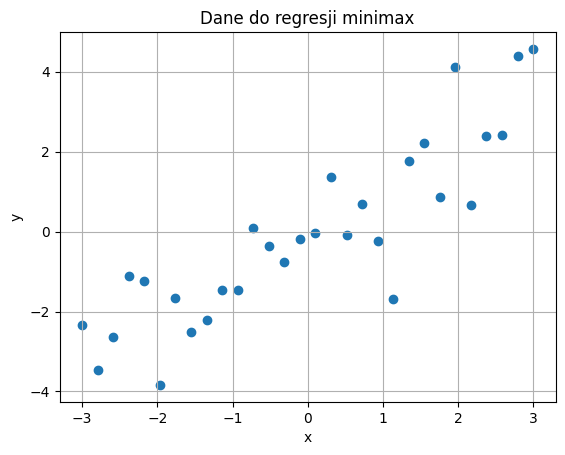

In [62]:
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Dane do regresji minimax")
plt.grid(True)
plt.show()

### Two constraints:
- $ \mathbf{ax_i + b - \varepsilon \le y_i}$
- $ \mathbf{-ax_i - b - \varepsilon \le -y_i}$

In [63]:
def solve_minimax_regression(x_data, y_data):
    n = len(x_data)

    n_base_vars = 5

    C_ineq = np.zeros((2 * n, n_base_vars))
    d_ineq = np.zeros(2 * n)
    
    for i in range(n):
        xi = x_data[i]
        yi = y_data[i]

        C_ineq[2*i] = [xi, -xi, 1, -1, -1]
        d_ineq[2*i] = yi

        C_ineq[2*i+1] = [-xi, xi, -1, 1, -1]
        d_ineq[2*i+1] = -yi

    k = 2 * n 
    C_final = np.hstack([C_ineq, np.eye(k)])
    d_final = d_ineq

    b_final = np.zeros(n_base_vars + k)
    b_final[4] = 1.0 
 
    wynik = revised_simplex(C_final, d_final, b_final, B0=None)
    
    if wynik["status"] == "optimal":
        res_x = wynik["x"]
        a = res_x[0] - res_x[1]
        b = res_x[2] - res_x[3]
        epsilon = res_x[4]
        return a, b, epsilon
    else:
        return None

In [64]:
a, b, epsilon = solve_minimax_regression(x,y)

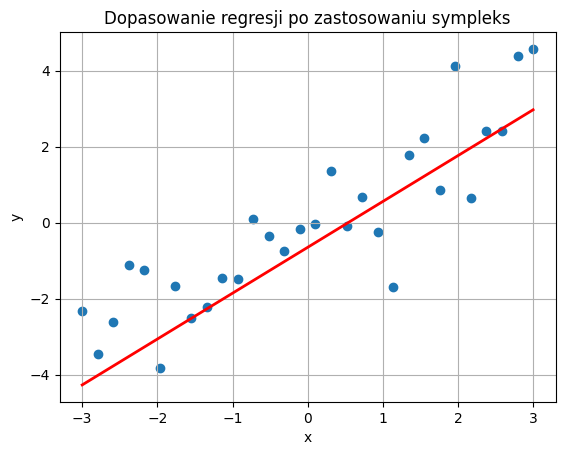

In [72]:
x_line = np.array([min(x), max(x)])
y_line = a * x_line + b

plt.scatter(x, y, label="Dane")
plt.plot(x_line, y_line, color='red', linewidth=2, label=f"Linia: y={a}x+{b}")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Dopasowanie regresji po zastosowaniu sympleks")
plt.grid(True)
plt.show()

## Dual problem implementation


**Decision Variables:**
We introduce two sets of dual variables for each data point $i=1,\dots,n$:
* $u_i \ge 0$: Lagrange multipliers for the upper bound constraints ($ax_i + b - y_i \le \varepsilon$).
* $v_i \ge 0$: Lagrange multipliers for the lower bound constraints ($-ax_i - b + y_i \le \varepsilon$).

**Objective Function:**
Maximize:

$$
\max_{u, v} \sum_{i=1}^{n} y_i (u_i - v_i)
$$

**Constraints:**

1.  **Corresponding to variable $a$**:
    $$
    \sum_{i=1}^{n} x_i (u_i - v_i) = 0
    $$

2.  **Corresponding to variable $b$**:
    $$
    \sum_{i=1}^{n} (u_i - v_i) = 0
    $$

3.  **Corresponding to variable $\varepsilon$** (the sum of all weights cannot exceed 1):
    $$
    \sum_{i=1}^{n} (u_i + v_i) \le 1
    $$

4.  **Non-negativity constraints:**
    $$
    u_i \ge 0, \quad v_i \ge 0 \quad \text{for each } i = 1, \ldots, n
    $$

##### Therefore, we must minimize:
$$
\min_{u, v} -\sum_{i=1}^{n} y_i (u_i - v_i)
$$

In [66]:
import time 

n = len(x)
n_base_vars = 5

C_ineq = np.zeros((2 * n, n_base_vars))
d_ineq = np.zeros(2 * n)

for i in range(n):
    xi = x[i]
    yi = y[i]
    C_ineq[2*i] = [xi, -xi, 1, -1, -1]
    d_ineq[2*i] = yi
    C_ineq[2*i+1] = [-xi, xi, -1, 1, -1]
    d_ineq[2*i+1] = -yi

k = 2 * n 
C_final = np.hstack([C_ineq, np.eye(k)])
d_final = d_ineq

b_final = np.zeros(n_base_vars + k)
b_final[4] = 1.0 

start = time.time()
wynik = revised_simplex(C_final, d_final, b_final, B0=None)
end = time.time()

if wynik["status"] == "optimal":
    res_x = wynik["x"]
    a = res_x[0] - res_x[1]
    b = res_x[2] - res_x[3]
    epsilon = res_x[4]
print(end - start)

0.02358388900756836


Czas: 0.0021 s
Wynik: y = 1.21x + -0.65, eps = 2.4086


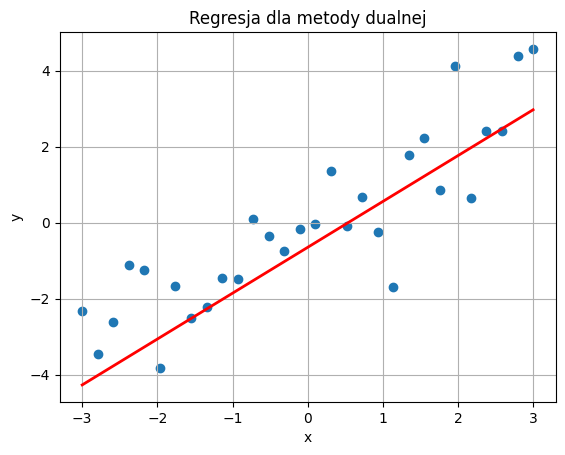

In [73]:
def solve_minimax_regression_dual(x_data, y_data):
    n = len(x_data)

    n_dual_vars = 2 * n
    
    n_constraints = 3
    C_eq = np.zeros((n_constraints, n_dual_vars))
    d_eq = np.zeros(n_constraints)

    C_eq[0, :n] = x_data
    C_eq[0, n:] = -x_data
    d_eq[0] = 0

    C_eq[1, :n] = 1.0
    C_eq[1, n:] = -1.0
    d_eq[1] = 0

    C_eq[2, :n] = 1.0
    C_eq[2, n:] = 1.0
    d_eq[2] = 1.0 

    slack_col = np.zeros((3, 1))
    slack_col[2, 0] = 1.0
    C_final = np.hstack([C_eq, slack_col])
    d_final = d_eq

    b_final = np.zeros(n_dual_vars + 1)

    b_final[:n] = -y_data
    b_final[n:2*n] = y_data
    
    start = time.time()
    wynik = revised_simplex(C_final, d_final, b_final, B0=None)
    end = time.time()
    
    if wynik["status"] == "optimal":
        res_vars = wynik["x"]
        u = res_vars[:n]
        v = res_vars[n:2*n]

        calculated_epsilon = np.sum(y_data * (u - v))

        support_indices = np.where(u + v > tol)[0]
        
            
        idx1 = support_indices[0]
        idx2 = support_indices[1]
        
        epsilon = calculated_epsilon
        
        Y1 = y_data[idx1] + (-epsilon if u[idx1] > tol else epsilon)
        Y2 = y_data[idx2] + (-epsilon if u[idx2] > tol else epsilon)

        calc_a = (Y1 - Y2) / (x_data[idx1] - x_data[idx2])
        calc_b = Y1 - calc_a * x_data[idx1]
        
        return calc_a, calc_b, epsilon, (end - start)


res_dual = solve_minimax_regression_dual(x, y)

a, b, ed, td = res_dual
print(f"Czas: {td:.4f} s")
print(f"Wynik: y = {a:.2f}x + {b:.2f}, eps = {ed:.4f}")

x_line = np.array([min(x), max(x)])
y_line = a * x_line + b

plt.scatter(x, y, label="Dane")
plt.plot(x_line, y_line, color='red', linewidth=2, label=f"Linia: y={a}x+{b}")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Regresja dla metody dualnej")
plt.grid(True)
plt.show()

### Time of the algorithm is approximately 10 times faster.